# DEM-GNN Rollout Evaluation

## Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import os
import time
import json 

from tqdm import tqdm, trange
from torch_geometric.nn.models import MLP
from IPython.display import clear_output

print(torch.cuda.is_available())
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)

True


## Loading and training on datasets

In [ ]:
from ML_functions import DEM_Dataset
dataset_name    = "N400_Mono"
[dataset_train]      = [DEM_Dataset(dataset_name, dataset_type, force_reload=False, bundle_size=1) for dataset_type in ["test"]]

In [ ]:
from Evaluation import GetExperimentSettings,EvaluateExperiment
exp_settings = GetExperimentSettings('N400Error','N400_Mono',push=True)
metric_dict = EvaluateExperiment(exp_settings,save_name='Error_Push')

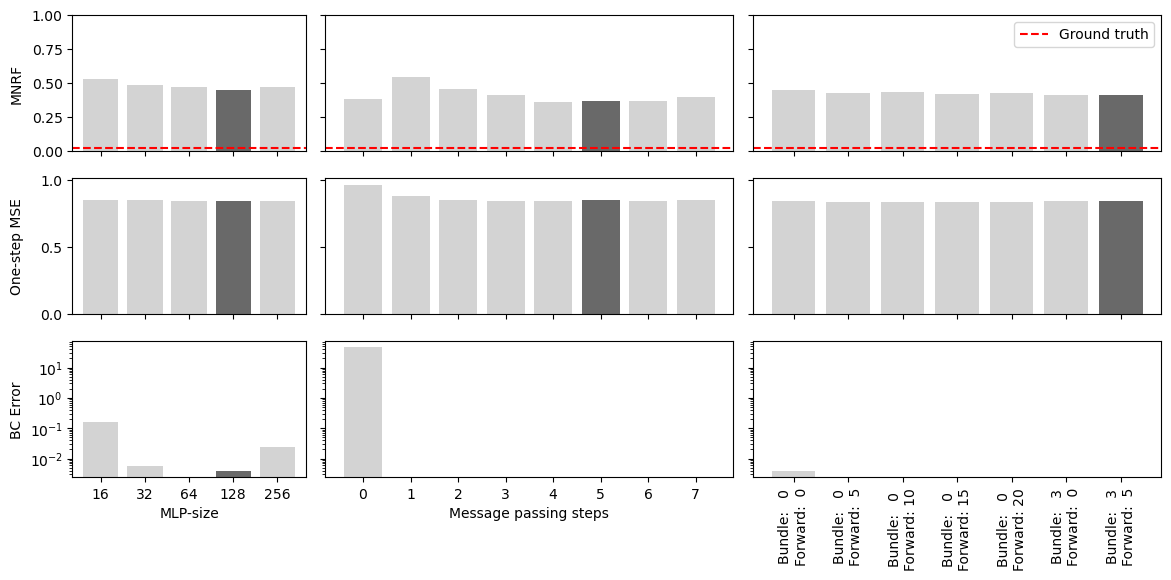

In [13]:
def OpenMetricJSON(save_name):
    filename = os.path.join(".",'Evaluation',f"{save_name}_metrics.json")
    with open(filename, 'r') as file:
        dict = json.load(file)
    return dict

def SplitMetricDict(dict):
    MNRF_dict = {key: dict[key] for key in dict if 'MNRF' in key}
    MSE_dict = {key: dict[key] for key in dict if 'MSE' in key}
    par_dict = {key: dict[key] for key in dict if 'Par' in key}
    return MNRF_dict, MSE_dict, par_dict

def PlotExperiment(dict,labels,column,highlight_idx):
    MNRF_dict, MSE_dict, par_dict = SplitMetricDict(dict)
    MNRF_values = list(MNRF_dict.values())[1:]
    MNRF_groundtruth = list(MNRF_dict.values())[0]
    MSE_values = list(MSE_dict.values())
    par_values = list(par_dict.values())

    colors = ['lightgrey']*len(MNRF_values)
    colors[highlight_idx] = 'dimgrey'

    axs[0,column].bar(labels,MNRF_values,color=colors,width=0.8)
    axs[0,column].axhline(MNRF_groundtruth,color='red', linestyle="--",label='Ground truth')
    axs[1,column].bar(labels,MSE_values,color=colors,width=0.8)
    if axs.shape[0] > 2:
        axs[2,column].bar(labels,par_values,color=colors,width=0.8)

def SplitDict(dictionary,substrings):
    sub_dict = {}
    keys = [[key for key in dictionary if substring in key] for substring in substrings]
    for key in np.concatenate(keys).tolist():
        sub_dict[key] = dictionary[key]
    return sub_dict

mm=1/25.4
fig, axs = plt.subplots(3,3,figsize=(300*mm,150*mm),sharex='col',sharey='row',gridspec_kw={'width_ratios': [4, 7,7]})

emb_dict = OpenMetricJSON(save_name='Embedding_Push')
PlotExperiment(emb_dict,labels=['16','32','64', '128','256'],column=0,highlight_idx=3)

msg_dict = OpenMetricJSON(save_name='N400msg_Push')
PlotExperiment(msg_dict,labels=['0','1','2', '3','4','5','6','7'],column=1,highlight_idx=5)

error_dict = OpenMetricJSON(save_name='Error_Push')
substrings = ['bundle','Allout']


forward_dict = SplitDict(error_dict,substrings= ['Groundtruth','Emb128','forward5','forward10','forward15','forward20'])
bundle_dict = SplitDict(error_dict,substrings= ['bundle','Allout'])

plot_dict = forward_dict | bundle_dict
bundle = [0,0,0,0,0,3,3]
forward = [0,5,10,15,20,0,5] 
labels = [f"Bundle: {b:>3}\nForward: {f:>2}" for b,f in zip(bundle,forward)]
PlotExperiment(plot_dict,labels,column=2,highlight_idx=-1)

axs[0,0].set_ylabel('MNRF')
axs[1,0].set_ylabel('One-step MSE')
axs[-1,0].set_ylabel("BC Error")

axs[-1,0].set_xlabel('MLP-size')
axs[-1,1].set_xlabel('Message passing steps')

axs[0,0].set_ylim([0,1])
axs[0,-1].set_ylim([0,1])
axs[-1,0].set_yscale("log")

axs[-1,-1].tick_params(axis='x',labelrotation=90)

fig.tight_layout()
fig.align_ylabels()
axs[0,-1].legend()

plt.show()

In [ ]:
error_dict = OpenMetricJSON(save_name='Error_Push')
substrings = ['bundle','Allout']
def SplitDict(dictionary,substrings):
    sub_dict = {}
    keys = [[key for key in dictionary if substring in key] for substring in substrings]
    for key in np.concatenate(keys).tolist():
        sub_dict[key] = dictionary[key]
    return sub_dict

fig, axs = plt.subplots(3,1,figsize=(100*mm,150*mm),sharex='col',sharey='row',gridspec_kw={'width_ratios': [1]})
axs=np.array([axs]).T

forward_dict = SplitDict(error_dict,substrings= ['Groundtruth','Emb128','forward5','forward10','forward15','forward20'])
bundle_dict = SplitDict(error_dict,substrings= ['bundle','Allout'])

plot_dict = forward_dict | bundle_dict
bundle = [0,0,0,0,0,3,3]
forward = [0,5,10,15,20,0,5] 
labels = [f"Bundle: {b:>3}\nForward: {f:>2}" for b,f in zip(bundle,forward)]
PlotExperiment(plot_dict,labels,column=0,highlight_idx=-1)

axs[0,0].set_ylabel('MNRF')
axs[1,0].set_ylabel('One-step MSE')
axs[-1,0].set_ylabel("BC Error")
axs[-1,0].tick_params(axis='x',labelrotation=90)

axs[0,0].set_ylim([0,1])
axs[1,0].set_ylim([0,1])
axs[-1,0].set_yscale("log")

In [ ]:
from Evaluation import GetExperimentSettings,EvaluateExperiment
exp_settings = GetExperimentSettings('2Sphere','2Sphere',push=True)
metric_dict = EvaluateExperiment(exp_settings,save_name='2Sphere')

In [ ]:
from Plotting import PlotTrainingLoss
dataset_name = 'N400_Mono'
model_ident = 'Allout'
PlotTrainingLoss(dataset_name,model_ident,push=True)


## Generating Rollouts

In [ ]:
from Evaluation import CompareModels, Evaluation
Evaluation_function=Evaluation(mode='mechanics_mean',print_results=True)
#model_idents = ["Allout",'Forward_Bundle','Forward','Bundle', 'Onestep']
metrics = CompareModels(dataset_name        = 'N400_Mono',
                        model_idents        = ['Emb16','Emb32','Emb64','Emb128','Emb256'],
                        Evaluation_function = Evaluation_function,
                        save_name           = "Embedding")

In [ ]:
metrics = CompareModels(dataset_name        = '2Sphere',
                        model_idents        = ['Allout'],
                        Evaluation_function = Evaluation_function)

In [16]:
from Plotting import PlotXYZ, PlotStressComparison
from ML_functions import LearnedSimulator, NormalizeData, GetModel, Rescale, NormalizePos, MaskTestData
from Encoding import SaveRolloutAsJSON
from Evaluation import ParticlesOutsideBoundary

dataset_name="N400_Mono"
model_ident = "Allout_Push"

model = GetModel(dataset_name,model_ident)[0]
AggregatedArgs = MaskTestData(dataset_name,"test")

Loaded model N400_Mono_Allout_Push


In [17]:
scale_name = f"{dataset_name}_bund{model.bundle_size}"
transform = T.Compose([T.Cartesian(False),T.Distance(norm=False,cat=True),NormalizeData(dataset_name,scale_name)])
Simulation = LearnedSimulator(model, scale_function = Rescale(dataset_name,scale_name),transform = transform)
for sample_idx in [0]:
    Simulation.Rollout(*AggregatedArgs,sample_idx,show_tqdm=True)
    if dataset_name == "2Sphere": 
        PlotXYZ(Simulation,t_max=100, normalize=False)
    SaveRolloutAsJSON(Simulation.ML_rollout,dataset_name,model_ident,sample_idx)
    print(f"Maximum Particles outside boundaries: {np.max(ParticlesOutsideBoundary(Simulation.ML_rollout,Simulation.BC_rollout)).astype(int)}")


Calculating BC


100%|██████████| 100/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 133.13it/s]


Calculating Learned Rollout


34it [00:02, 14.46it/s]                        


Maximum Particles outside boundaries: 0


In [ ]:
Simulation.BC_rollout.shape

In [ ]:
for bc in Simulation.BC_rollout:
    print(bc[0].shape) 

## Evaluating Rollouts

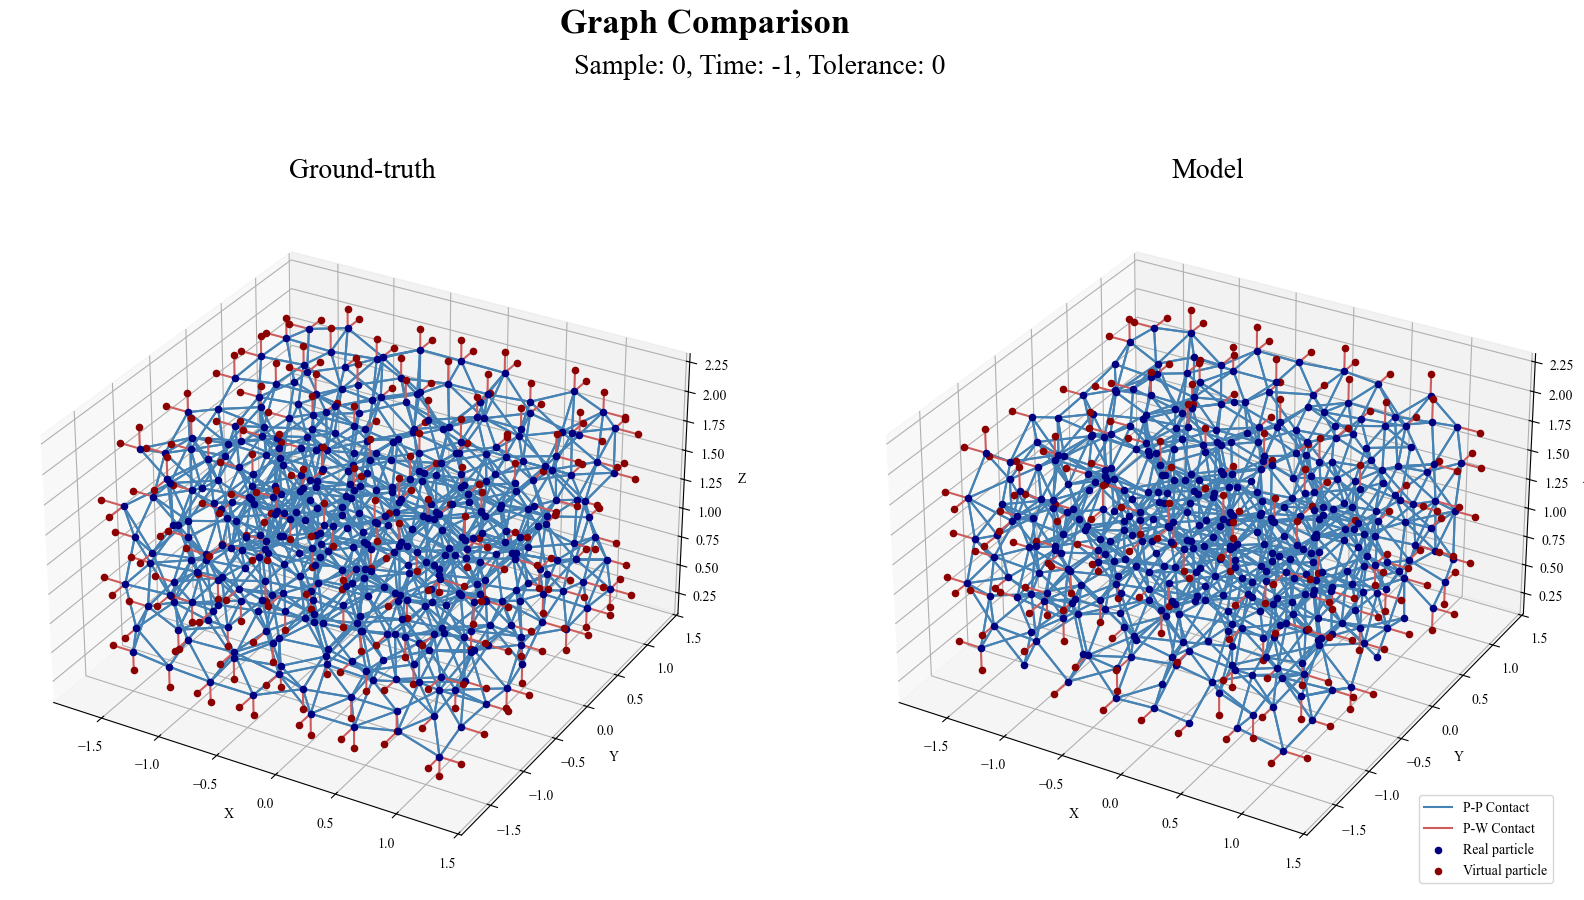

In [31]:
from Plotting import PlotGraphComparison
save = False
show = True
for t in [-1]:  
    fig = PlotGraphComparison(t,Simulation,sample_idx,Simulation.tol,plot_lines=True)
    if save == True: plt.savefig(f"{os.getcwd()}\\Figures\\Plots\\Graph_Sample{sample_idx}_Time{t}_Tol{str(Simulation.tol)[2:]}.png",bbox_inches='tight')     
    if show == True: plt.show()

In [105]:
from Evaluation import AggregatedRollouts,NormalizedResultantForce
from ML_functions import GetModel, MaskTestData

dataset_name="2Sphere "
model_ident = "redo"

model = GetModel(dataset_name,model_ident)[0]
AggregatedArgs = MaskTestData(dataset_name,"test")

datalist_ML, datalist_GT,bc_agr = AggregatedRollouts(model,AggregatedArgs,test_dataset_name=dataset_name)
MNRF_pred = np.array([[np.mean(NormalizedResultantForce(data)) for data in datalist_sample] for datalist_sample in tqdm(datalist_ML,disable=False)])
MNRF_groundtruth = np.array([[np.mean(NormalizedResultantForce(data)) for data in datalist_sample] for datalist_sample in tqdm(datalist_GT,disable=False)])

No Trained model


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\20182319\\Documents\\Master\\Graduation\\Repos\\DEM-GNN\\Data\\raw\\2Sphere _Data.npy'

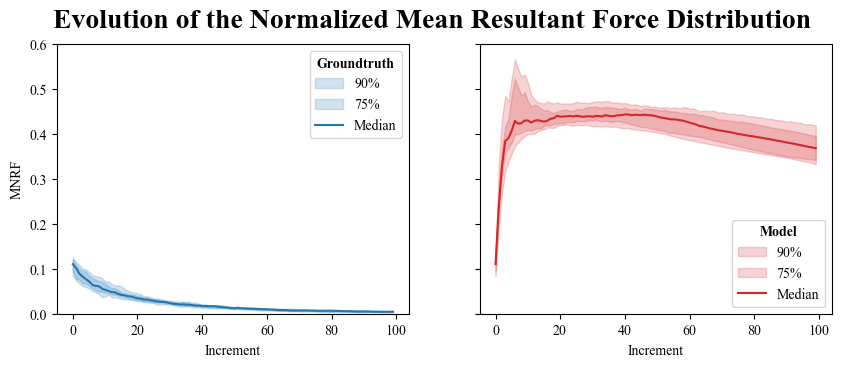

In [60]:
from Plotting import PlotForceDistributionComparison
quantiles = [10,25,50]
fig, ax = PlotForceDistributionComparison(MNRF_groundtruth.T,MNRF_pred.T,quantiles,True)
ax[0].set_ylabel('MNRF')
ax[0].set_ylim([0,0.6])
fig.set_size_inches(10,3.5)

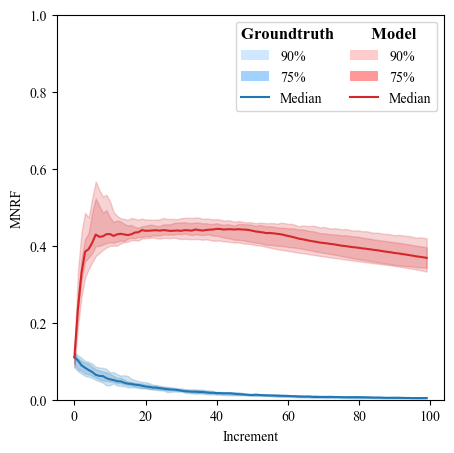

In [103]:
from Plotting import PlotFnormDistribution
Fnorm_GT = MNRF_groundtruth.T
Fnorm_ML = MNRF_pred.T
fig, ax = plt.subplots(1,1,figsize=(5, 5),sharey=True,sharex=True)
plt.rcParams["font.family"] = "Times New Roman"

PlotFnormDistribution(ax,quantiles,Fnorm_GT,"blue")
ax.legend(ncol=2,title="Groundtruth",title_fontproperties={"size":10,"weight":"bold"})
ax.set_ylabel("MNRF")
ax.set_xlabel("Increment")

PlotFnormDistribution(ax,quantiles,Fnorm_ML,"red")
leg = ax.legend(ncol=2,title="Groundtruth         Model",title_fontproperties={"size":12,"weight":"bold"})
leg._legend_box.align = "left"
leg.legend_handles[3].set_facecolor([1,0,0,0.2])
leg.legend_handles[3].set_edgecolor([1,0,0,0])
leg.legend_handles[4].set_facecolor([1,0,0,0.4])
leg.legend_handles[4].set_edgecolor([1,0,0,0])

g=0.7
r=0.4
leg.legend_handles[0].set_facecolor([r,g,1,0.3])
leg.legend_handles[0].set_edgecolor([r,g,1,0])
leg.legend_handles[1].set_facecolor([r,g,1,0.6])
leg.legend_handles[1].set_edgecolor([r,g,1,0])

ax.set_xlabel("Increment")
ax.set_ylim([0,1])
fig.savefig(r"C:\Users\20182319\OneDrive - TU Eindhoven\Graduation\Figures\Experiment_Error.png",dpi=1200)

In [42]:
Fnorm_ML.shape

(100, 100)

In [ ]:
from Plotting import PlotFres
from Evaluation import NormalizedResultantForce
list = [NormalizedResultantForce(data) for data in Simulation.GroundTruth]
Fnorm_ML = np.array([NormalizedResultantForce(data) for data in Simulation.ML_rollout])
Fnorm_GT = np.array([NormalizedResultantForce(data) for data in Simulation.GroundTruth])
fig = PlotFres(np.mean(Fnorm_GT,axis=1),np.mean(Fnorm_ML,axis=1))

In [ ]:
from Plotting import PlotStressComparison
PlotStressComparison(Simulation)

In [ ]:
from Plotting import PlotForceDistributionComparison
quantiles = [5,10,25,50]
fig, ax = PlotForceDistributionComparison(Fnorm_GT,Fnorm_ML,quantiles,True)

In [ ]:
Fnorm_GT.shape

In [ ]:
Fnorm_GT.shape

In [ ]:
from Evaluation import GetInternalStressRollout
stress_evo = GetInternalStressRollout(Simulation)

In [ ]:
import pyvista as pv
from Plotting import MakeGIF, PlotMeshNormals

gifname = f"{dataset_name}_GT_deform"
gifname = f"{dataset_name}_{model_ident}_deform"

datalist = Simulation.GroundTruth
datalist = Simulation.ML_rollout
MakeGIF(datalist,gifname,fps=8,color='lightblue',deformation=True)

#data = Rollout.ML_rollout[10]
#data = Rollout.GroundTruth[0]
#PlotMeshNormals(data)


## Testing New Code

### Benchmarking topology functions

In [ ]:
from Encoding import ConstructTopology
from ML_functions import MaskTestData
dataset_name = 'N400_Mono'
AggregatedArgs = MaskTestData(dataset_name,'test')
data,top,bc = AggregatedArgs
data = data[0]
top = top[0]
bc = bc[0]
t=0
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]


par_data = data[0]
super_topology = ConstructTopology(par_data,BC_t,6)-1

In [ ]:
data,top,bc = AggregatedArgs
top.shape

In [ ]:
from Encoding import TopologyFromPlausibleTopology_old, TopologyFromPlausibleTopology

tol=0
t0 = time.time()
topology_0 = ConstructTopology(par_data,BC_t,tol)-1
t1 = time.time()
topology_1 = TopologyFromPlausibleTopology_old(super_topology,par_data,BC_t,tol)
t2 = time.time()
topology_2 = TopologyFromPlausibleTopology(super_topology,par_data,BC_t,tol)
t3 = time.time()

print(np.all(topology_0 == topology_1))
print(np.all(topology_1 == topology_2))
print(t1-t0)
print(t2-t1)
print(t3-t2)

In [ ]:
AggregatedArgs = MaskTestData(dataset_name)
data,top,bc = AggregatedArgs
par_data = data[0][0]
print(par_data)
R_avg = par_data[0,3]
noise_factor = 0.01
standard_deviation = noise_factor*R_avg
noise = np.array(standard_deviation*torch.randn((par_data.shape[0],3)))
par_data[:,:3]+=noise
print(par_data)

In [ ]:
t=40
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]
bc=BC_t
par_data = data[t]
top0 = ConstructTopology(par_data,bc,0)-1

from Encoding import TopologyFromPlausibleTopology
topology_sub = TopologyFromPlausibleTopology(super_topology,par_data,BC_t,0)

topology_sub == top0,topology_sub

In [ ]:
from Evaluation import GetGamma
gamma = GetGamma(data)
gamma

### Testing normalization

In [ ]:
def AverageDX(data):
    norm = torch.norm(data.y,dim=1)
    return torch.mean(norm)

dataset_test.y.abs().mean().item()

In [ ]:
def PrintDatasetStats(dataset):
    torch.set_printoptions(sci_mode=False, linewidth=150)
    print(f"x_max:      {dataset.x.max(dim=0)[0]}")
    print(f"y_mean:     {dataset.y.mean(dim=0)}")
    print(f"y_std:      {dataset.y.std(dim=0)}")
    print(f"edge_mean:  {dataset.edge_attr.mean(dim=0)}")
    print(f"edge_std:   {dataset.edge_attr.std(dim=0)}")
    print("\n")
    torch.set_printoptions(profile='default')

PrintDatasetStats(dataset_train)
#PrintDatasetStats(dataset_train_push)

fig = plt.hist(dataset_train_push.push_forward_steps,100)

## Old Code

In [ ]:
def FilterStart(dataset):
    idx = np.nonzero([data.time == 0 for data in dataset])
    return torch.utils.data.Subset(dataset_test,idx)[0]

#dataset_test_start = FilterStart(dataset_test)

In [ ]:
from Encoding import ToPytorchData, GetLength

def GetLimits(data):
    max = [torch.max(data.x[:,i]) for i in [0, 1, 2]]
    min = [torch.min(data.x[:,i]) for i in [0, 1, 2]]
    max = torch.stack(max)
    min = torch.stack(min)
    limits = torch.stack([min,max],dim=1)
    return limits


In [ ]:
from Encoding import load
def SplitData(dataset_name,data_split):
    loaded_data = load(dataset_name)
    splits=np.array(data_split)*loaded_data[0].shape[0]
    test_data = [np.split(data,splits.astype(int))[2] for data in loaded_data]
    return test_data

In [ ]:
from Evaluation import GetContactForce
from Encoding import ConvertToDirected
data = Rollout.GroundTruth[0].clone()
force = GetContactForce(data)
GT = np.loadtxt('PairContact001.txt')

data =ConvertToDirected(data)
force2 = GetContactForce(data)

print(torch.norm(force,dim=1).size())
print(torch.norm(force2,dim=1))

torch.all(np.round(GT[:,2],2)==torch.round(torch.norm(force2,dim=1),decimals=2))

In [ ]:
from Plotting import GetInternalStressRollout
stress = GetInternalStressRollout(Rollout)
torch.set_printoptions(4)
print("Stress at time 0")
print(torch.round(stress[0],decimals=8)),
print("\nStress at time 99")
print(torch.round(stress[-1],decimals=1))

In [ ]:
from Plotting import PlotContactVectorAndForce, GetAllContactpoints,AxesLimits
data = Rollout.GroundTruth[0]
BC = Rollout.BC_rollout[3]
fig,axs = PlotContactVectorAndForce(data,BC)
for ax in axs: AxesLimits(ax,BC)

In [ ]:
class UniformMLP(torch.nn.Sequential):
    def __init__(self,input_size,hidden_size,output_size,num_hidden_layers,activation_function=torch.nn.ReLU()):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers,
        self.activation_function=activation_function
        hidden_input_size = input_size
        for i in range(num_hidden_layers):
            self.add_module(f"dense{i}",torch.nn.Linear(hidden_input_size,hidden_size))
            self.add_module(f"act{i}",activation_function)
            hidden_input_size = hidden_size
        self.add_module(f"output",torch.nn.Linear(hidden_size,output_size))
